In [1]:
import wradlib as wrl
import numpy as np
import pylab as pl
import os

from mpl_toolkits.mplot3d import Axes3D
import pyart

C:\Users\irene\Anaconda3\envs\wradlib3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:

def bbox(*args):
    """Get bounding box from a set of radar bin coordinates
    """
    x = np.array([])
    y = np.array([])
    for arg in args:
        x = np.append(x, arg[:, 0])
        y = np.append(y, arg[:, 1])
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    return xmin, xmax, ymin, ymax

In [3]:
datalist = os.listdir('./data')

In [4]:
data_vol = []
th_vals = []
for fname in datalist:
    data, attrs = wrl.io.read_edge_netcdf(os.path.join('./data',fname))
    data_vol.append(data)
    th_vals.append(attrs['Elevation'])
data_vol = np.array(data_vol)
th_vals = np.array(th_vals)

In [5]:
sitecoords = attrs['sitecoords'][:2]

In [6]:
data_vol.shape

(14, 360, 240)

In [7]:
r = np.arange(500,120500,500)
az = np.arange(0, 360)

(<matplotlib.axes._subplots.AxesHostAxesSubplot at 0x25c39e43a20>,
 <matplotlib.collections.QuadMesh at 0x25c3a62d940>)

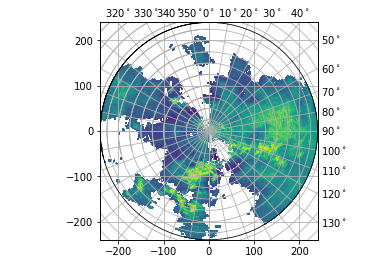

In [8]:
wrl.vis.plot_ppi(data_vol[0], cg=True)

# Convert to cartesian

In [9]:
proj_wgs84 = wrl.georef.epsg_to_osr(4326)

In [10]:
lon0_gr = 120.363746643
lat0_gr = 14.8221387863

wgs84 = wrl.georef.get_default_projection()
a = wgs84.GetSemiMajor()
b = wgs84.GetSemiMinor()
rad = wrl.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' + 
                                   '+lat_0={lat:f} +a={a:f} ' +
                                   '+b={b:f}').format(lon=lon0_gr,
                                                      lat=lat0_gr,
                                                      a=a, b=b))

In [11]:
# borders_rad = np.zeros_like(borders)
# for i in range(len(borders)):
#     borders_rad[i] = wrl.georef.reproject(borders[i], projection_source=wgs84, projection_target=rad )
    
# # borders3d = []
# # for i in np.arange(len(borders_rad)):
# #     borders3d.append(np.c_[borders_rad[i],np.zeros(len(borders_rad[i]))])

In [12]:
coord = wrl.georef.spherical_to_centroids(r, az, 0, sitecoords,
                                              proj=rad)
coord = coord[..., 0:2]
coord = coord.reshape(-1, coord.shape[-1])

In [13]:
# define target grid for composition
xmin, xmax, ymin, ymax = bbox(coord)

In [14]:
x1 = np.linspace(xmin, xmax + 1000., 1000.)
y1 = np.linspace(ymin, ymax + 1000., 1000.)
z1 = np.zeros_like(x1)
grid_coords = wrl.util.gridaspoints(y1, x1)

C:\Users\irene\Anaconda3\envs\wradlib3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.
C:\Users\irene\Anaconda3\envs\wradlib3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [15]:
sub_gridded = wrl.comp.togrid(coord, grid_coords, r.max() + 500.,
                              coord.mean(axis=0),
                              data_vol[0].ravel(),
                              wrl.ipol.Nearest)

In [16]:
sub_gridded_ = sub_gridded.reshape((1000,1000))

In [17]:
sub_gridded_3d = np.zeros((1000,1000,1))
sub_gridded_3d[:,:,0] = sub_gridded_

In [18]:
xx1,yy1 = np.meshgrid(x1,y1)

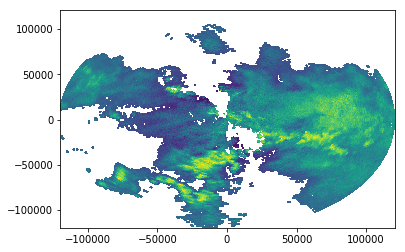

In [19]:
pl.pcolormesh(x1,y1,sub_gridded_)

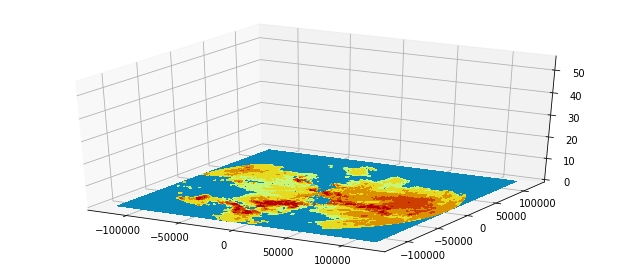

In [20]:
fig = pl.figure(figsize=pl.figaspect(0.2)*1.5)
ax1 = fig.add_subplot(121, projection='3d')

ax1.contourf(xx1,yy1,np.nan_to_num(sub_gridded_),zdir='z', offset=0.0, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)

In [21]:
r = r
th = th_vals
th_res = 0
data = data_vol[:,90,:]
rf = 1.0

d1 = np.asanyarray(r.copy())
d2 = np.asanyarray(th.copy())
x = d1
y = d2

# coordinates for all vertices
xx, yy = np.meshgrid(x, y)

# otherwise plane trigonometry will do
xxx = xx * np.cos(np.radians(yy)) / rf
yyy = xx * np.sin(np.radians(yy)) / rf

In [22]:
x2 = np.linspace(0,120000,240)
y2 = d2
xx2, yy2 = np.meshgrid(x2, y2)
x3 = xx2 * np.cos(np.radians(yy2))
y3 = xx2 * np.sin(np.radians(yy2))

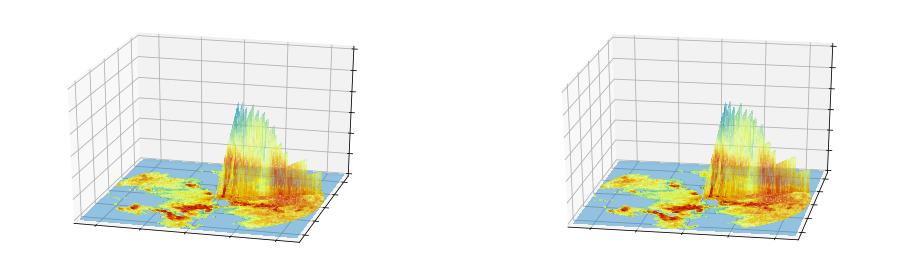

In [23]:
fig = pl.figure(figsize=pl.figaspect(0.3)*1.2)

ax1 = fig.add_subplot(121, projection='3d')

cset = [[],[],[]]
cset[0] = ax1.contourf(xx1,yy1,np.nan_to_num(sub_gridded_),zdir='z', offset=0.0, levels=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, alpha=0.4)
cset[2] = ax1.contourf(x3, np.array(data), y3, zdir='y', offset=0.0,levels=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, alpha=0.4)

ax1.view_init(25, 285)

# setting 3D-axis-limits:    
ax1.set_xlim3d(-120000,120000)
ax1.set_ylim3d(-120000,120000)
ax1.set_zlim3d(0,12000)

ax2 = fig.add_subplot(122, projection='3d')

cset = [[],[],[]]
cset[0] = ax2.contourf(xx1,yy1,np.nan_to_num(sub_gridded_),zdir='z', offset=0.0, levels=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, alpha=0.4)
cset[2] = ax2.contourf(x3, np.array(data), y3, zdir='y', offset=0.0,levels=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, alpha=0.4)

ax2.view_init(25, 280)

# setting 3D-axis-limits:    
ax2.set_xlim3d(-120000,120000)
ax2.set_ylim3d(-120000,120000)
ax2.set_zlim3d(0,12000)

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])


pl.savefig('rad4.png', dpi=600, bbox_inches='tight')

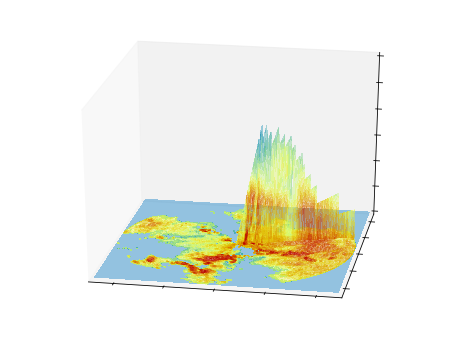

In [24]:
fig = pl.figure(figsize=(8,6))
ax1 = fig.add_subplot(111, projection='3d')

cset = [[],[],[]]
cset[0] = ax1.contourf(xx1,yy1,np.nan_to_num(sub_gridded_),zdir='z', offset=0.0, levels=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, alpha=0.4)
cset[2] = ax1.contourf(x3, np.array(data), y3, zdir='y', offset=0.0,levels=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, alpha=0.4)

ax1.view_init(25, 280)

# setting 3D-axis-limits:    
ax1.set_xlim3d(-120000,120000)
ax1.set_ylim3d(-120000,120000)
ax1.set_zlim3d(0,12000)

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

ax1.grid(False)

pl.savefig('rad1.png', dpi=600, bbox_inches='tight')

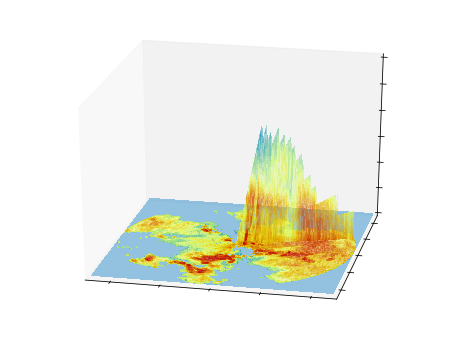

In [25]:
fig = pl.figure(figsize=(8,6))
ax2 = fig.add_subplot(111, projection='3d')

cset = [[],[],[]]
cset[0] = ax2.contourf(xx1,yy1,np.nan_to_num(sub_gridded_),zdir='z', offset=0.0, levels=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, alpha=0.4)
cset[2] = ax2.contourf(x3, np.array(data), y3, zdir='y', offset=0.0,levels=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, alpha=0.4)

ax2.view_init(25, 282)

# setting 3D-axis-limits:    
ax2.set_xlim3d(-120000,120000)
ax2.set_ylim3d(-120000,120000)
ax2.set_zlim3d(0,12000)

ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])

ax2.grid(False)

pl.savefig('rad2.png', dpi=600, bbox_inches='tight')

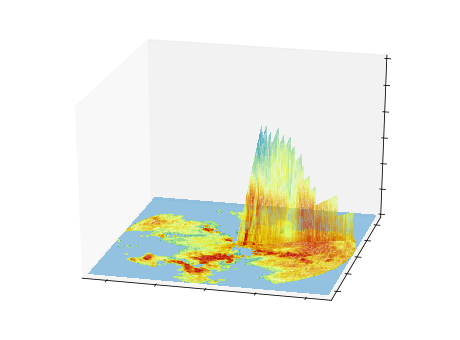

In [26]:
fig = pl.figure(figsize=(8,6))
ax2 = fig.add_subplot(111, projection='3d')

cset = [[],[],[]]
cset[0] = ax2.contourf(xx1,yy1,np.nan_to_num(sub_gridded_),zdir='z', offset=0.0, levels=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, alpha=0.4)
cset[2] = ax2.contourf(x3, np.array(data), y3, zdir='y', offset=0.0,levels=20, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, alpha=0.4)

ax2.view_init(25, 284)

# setting 3D-axis-limits:    
ax2.set_xlim3d(-120000,120000)
ax2.set_ylim3d(-120000,120000)
ax2.set_zlim3d(0,12000)

ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])

ax2.grid(False)

pl.savefig('rad3.png', dpi=600, bbox_inches='tight')

In [27]:
ax1.grid(False)